# Tuning Light Gradient Boosting

In [29]:
import pandas as pd 
import numpy as np 
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, auc
import optuna
from optuna_integration import LightGBMPruningCallback
import matplotlib.pyplot as plt 
import seaborn as sns 

In [9]:
xtrain = pd.read_csv('scaled_data/xtrain.csv', index_col = 0)
xtest = pd.read_csv('scaled_data/xtest.csv', index_col = 0)
ytrain = pd.read_csv('scaled_data/ytrain.csv', index_col = 0)
ytest = pd.read_csv('scaled_data/ytest.csv', index_col = 0)

### Set LightGBM Datasets

In [31]:
lgb_train = lgb.Dataset(xtrain, label = ytrain, free_raw_data = False)
lgb_test = lgb.Dataset(xtest, label = ytest, reference = lgb_train, free_raw_data = False)

### Train with Core Parameters

In [11]:
core_params = {
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'learning_rate' : 0.05,
    'num_leaves' : 31,
    'metric' : 'auc'
}

In [37]:
def train_gbm(params, train_set, test_set, init_gbm = None, boost_rounds = 100, early_stopping_rounds = 0, metric = 'auc'):

    evals_result = {}

    gbm = lgb.train(params,
                    train_set,
                    init_model = init_gbm,
                    num_boost_round = boost_rounds,
                    # early_stopping_round = early_stopping_rounds,
                    valid_sets = [test_set],
                    # evals_result = evals_result,
                    # verbose_eval = True
    )
    
    y_true = test_set.label

    y_pred = gbm.predict(test_set.data)

    fpr, tpr, threshold = roc_curve(y_true, y_pred)

    roc_auc = auc(fpr, tpr)

    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    _ = plt.plot(fpr, tpr, 'r')

    return gbm, evals_result

[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038


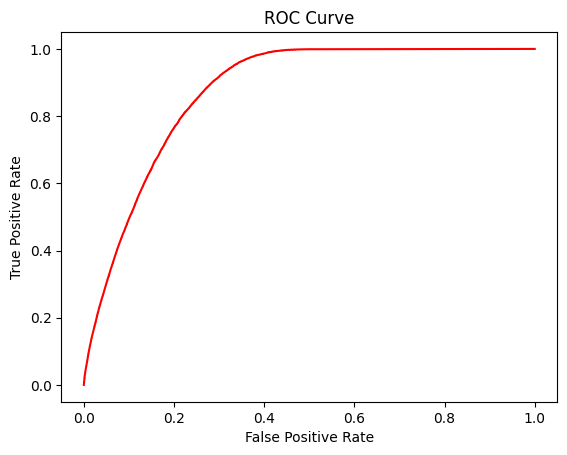

In [38]:
model, evals = train_gbm(core_params, lgb_train, lgb_test)

## Hyperparameter Tuning with Optuna

In [43]:
# define the objective function
def objective(trial: optuna.Trial, 
              train,
              test) -> float:
    
    # define the hyperparameters to tune
    hyperparams = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 3e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'bagging_fraction' : trial.suggest_float('bagging_fraction', 0.5, 0.9),
        'is_unbalance' : True
    }

    # pruning
    pruning_callback = LightGBMPruningCallback(trial, 'auc')

    # train model
    lgbm = lgb.train(hyperparams, train, valid_sets = [test], callbacks = [pruning_callback])

    y_pred_proba = lgbm.predict(xtest, num_iteration = lgbm.best_iteration)

    roc_auc = roc_auc_score(ytest, y_pred_proba)

    return float(roc_auc)

In [44]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, 
                                       train = lgb_train,
                                       test = lgb_test),
                n_trials = 50)

[I 2024-07-29 18:29:41,541] A new study created in memory with name: no-name-e0444f79-a2d3-4bc9-b05e-f3c1843e843d


[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-29 18:30:04,552] Trial 0 finished with value: 0.8764065030006134 and parameters: {'num_leaves': 144, 'max_depth': 8, 'learning_rate': 0.03466391518429615, 'n_estimators': 813, 'min_child_samples': 21, 'colsample_bytree': 0.8031928366234566, 'reg_alpha': 0.44029615310424686, 'reg_lambda': 0.8869632556539264, 'bagging_fraction': 0.7914518542159222}. Best is trial 0 with value: 0.8764065030006134.
/Users/owenxuli/Documents/GitHub/insurance-response-classifier/insurance/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[LightGBM] [Fatal] Reducing `min_data_in_l

[LightGBM] [Warning] bagging_fraction is set=0.579537420550804, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.579537420550804
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Warning] bagging_fraction is set=0.579537420550804, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.579537420550804
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038


[I 2024-07-29 18:30:10,769] Trial 1 finished with value: 0.8774680807658308 and parameters: {'num_leaves': 18, 'max_depth': 9, 'learning_rate': 0.1732080006922778, 'n_estimators': 485, 'min_child_samples': 12, 'colsample_bytree': 0.6532730571679977, 'reg_alpha': 0.2824691927675552, 'reg_lambda': 0.8127125917275994, 'bagging_fraction': 0.579537420550804}. Best is trial 1 with value: 0.8774680807658308.
/Users/owenxuli/Documents/GitHub/insurance-response-classifier/insurance/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.579537420550804, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.579537420550804
[LightGBM] [Warning] bagging_fraction is set=0.579537420550804, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.579537420550804
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038


[I 2024-07-29 18:30:19,099] Trial 2 finished with value: 0.8757198915907409 and parameters: {'num_leaves': 40, 'max_depth': 10, 'learning_rate': 0.16094370222893722, 'n_estimators': 517, 'min_child_samples': 57, 'colsample_bytree': 0.929779852906037, 'reg_alpha': 0.11785252142972956, 'reg_lambda': 0.8555307419245604, 'bagging_fraction': 0.8280164461260833}. Best is trial 1 with value: 0.8774680807658308.
/Users/owenxuli/Documents/GitHub/insurance-response-classifier/insurance/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.579537420550804, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.579537420550804
[LightGBM] [Warning] bagging_fraction is set=0.579537420550804, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.579537420550804
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038


[I 2024-07-29 18:30:25,436] Trial 3 finished with value: 0.8770743433752878 and parameters: {'num_leaves': 9, 'max_depth': 13, 'learning_rate': 0.08614100075986704, 'n_estimators': 604, 'min_child_samples': 92, 'colsample_bytree': 0.8154984807850667, 'reg_alpha': 0.9447605870272505, 'reg_lambda': 0.6587071846838388, 'bagging_fraction': 0.5439482120602344}. Best is trial 1 with value: 0.8774680807658308.
/Users/owenxuli/Documents/GitHub/insurance-response-classifier/insurance/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.579537420550804, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.579537420550804
[LightGBM] [Warning] bagging_fraction is set=0.579537420550804, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.579537420550804
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-07-29 18:30:44,149] Trial 4 finished with value: 0.8765875589024418 and parameters: {'num_leaves': 120, 'max_depth': 10, 'learning_rate': 0.028457787133937085, 'n_estimators': 650, 'min_child_samples': 40, 'colsample_bytree': 0.9209943523198492, 'reg_alpha': 0.8179871242987509, 'reg_lambda': 0.17136473964298424, 'bagging_fraction': 0.649727215430886}. Best is trial 1 with value: 0.8774680807658308.
/Users/owenxuli/Documents/GitHub/insurance-response-classifier/insurance/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.579537420550804, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.579537420550804
[LightGBM] [Warning] bagging_fraction is set=0.579537420550804, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.579537420550804
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-29 18:31:06,062] Trial 5 finished with value: 0.8744545516883747 and parameters: {'num_leaves': 113, 'max_depth': 18, 'learning_rate': 0.08992144887873323, 'n_estimators': 798, 'min_child_samples': 49, 'colsample_bytree': 0.6484026435509374, 'reg_alpha': 0.18383695752129217, 'reg_lambda': 0.557984659548473, 'bagging_fraction': 0.6899441046531497}. Best is trial 1 with value: 0.8774680807658308.
/Users/owenxuli/Documents/GitHub/insurance-response-classifier/insurance/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[LightGBM] [Fatal] Reducing `min_data_in_l

[LightGBM] [Warning] bagging_fraction is set=0.579537420550804, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.579537420550804
[LightGBM] [Warning] bagging_fraction is set=0.579537420550804, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.579537420550804
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832

[I 2024-07-29 18:31:11,587] Trial 7 pruned. Trial was pruned at iteration 263.


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038


[I 2024-07-29 18:31:14,874] Trial 8 pruned. Trial was pruned at iteration 104.


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038


[I 2024-07-29 18:31:15,602] Trial 9 pruned. Trial was pruned at iteration 33.
[I 2024-07-29 18:31:15,645] Trial 10 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:31:15,676] Trial 11 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:31:15,737] Trial 12 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:31:15,801] Trial 13 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_fraction is s

[I 2024-07-29 18:31:15,866] Trial 14 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003564 seconds.
You can set `

[I 2024-07-29 18:31:20,952] Trial 15 pruned. Trial was pruned at iteration 216.
[I 2024-07-29 18:31:21,044] Trial 16 pruned. Trial was pruned at iteration 1.
[I 2024-07-29 18:31:21,082] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:31:21,111] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:31:21,161] Trial 19 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Curren

[I 2024-07-29 18:31:21,224] Trial 20 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Curren

[I 2024-07-29 18:31:21,434] Trial 21 pruned. Trial was pruned at iteration 5.
[I 2024-07-29 18:31:21,525] Trial 22 pruned. Trial was pruned at iteration 1.
[I 2024-07-29 18:31:21,604] Trial 23 pruned. Trial was pruned at iteration 2.
[I 2024-07-29 18:31:21,641] Trial 24 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2024-07-29 18:31:29,767] Trial 25 pruned. Trial was pruned at iteration 263.
[I 2024-07-29 18:31:29,811] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:31:29,879] Trial 27 pruned. Trial was pruned at iteration 1.
[I 2024-07-29 18:31:29,919] Trial 28 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Curren

[I 2024-07-29 18:31:58,944] Trial 29 finished with value: 0.8752042811705775 and parameters: {'num_leaves': 154, 'max_depth': 13, 'learning_rate': 0.03553942486213639, 'n_estimators': 875, 'min_child_samples': 26, 'colsample_bytree': 0.7944676284967704, 'reg_alpha': 0.4195637210311028, 'reg_lambda': 0.3381324538393738, 'bagging_fraction': 0.7242415779452588}. Best is trial 1 with value: 0.8774680807658308.
/Users/owenxuli/Documents/GitHub/insurance-response-classifier/insurance/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-07-29 18:31:59,046] Trial 30 pruned. Trial was pruned at iteration 2.
[I 2024-07-29 18:31:59,091] Trial 31 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:31:59,142] Trial 32 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Curren

[I 2024-07-29 18:31:59,182] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:31:59,229] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:31:59,268] Trial 35 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003750 seconds.
You can set `

[I 2024-07-29 18:32:05,555] Trial 36 pruned. Trial was pruned at iteration 184.
[I 2024-07-29 18:32:05,622] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:32:05,665] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:32:05,720] Trial 39 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Curren

[I 2024-07-29 18:32:12,233] Trial 40 pruned. Trial was pruned at iteration 166.
[I 2024-07-29 18:32:12,295] Trial 41 pruned. Trial was pruned at iteration 2.
[I 2024-07-29 18:32:12,330] Trial 42 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Curren

[I 2024-07-29 18:32:21,692] Trial 43 finished with value: 0.8738513633179577 and parameters: {'num_leaves': 38, 'max_depth': 12, 'learning_rate': 0.21462805017609016, 'n_estimators': 578, 'min_child_samples': 97, 'colsample_bytree': 0.9264862670666798, 'reg_alpha': 0.06424467437794024, 'reg_lambda': 0.703925922583275, 'bagging_fraction': 0.7740142738376083}. Best is trial 1 with value: 0.8774680807658308.
/Users/owenxuli/Documents/GitHub/insurance-response-classifier/insurance/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-07-29 18:32:21,741] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:32:21,783] Trial 45 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Curren

[I 2024-07-29 18:32:28,860] Trial 46 finished with value: 0.8763746653221762 and parameters: {'num_leaves': 44, 'max_depth': 20, 'learning_rate': 0.1300489519597601, 'n_estimators': 403, 'min_child_samples': 62, 'colsample_bytree': 0.9682490225648378, 'reg_alpha': 0.6380440619854233, 'reg_lambda': 0.9720400845014672, 'bagging_fraction': 0.6868592417114816}. Best is trial 1 with value: 0.8774680807658308.
/Users/owenxuli/Documents/GitHub/insurance-response-classifier/insurance/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038


[I 2024-07-29 18:32:29,202] Trial 47 pruned. Trial was pruned at iteration 16.
[I 2024-07-29 18:32:29,265] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2024-07-29 18:32:29,303] Trial 49 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Current value: bagging_fraction=0.5470104613730861
[LightGBM] [Info] Number of positive: 49584, number of negative: 353084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 402668, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123139 -> initscore=-1.963038
[LightGBM] [Info] Start training from score -1.963038
[LightGBM] [Warning] bagging_fraction is set=0.5470104613730861, subsample=0.8811570078334832 will be ignored. Curren

In [45]:
print('Best score: ', study.best_trial.value)
print('Best hyperparameters: ', study.best_params)

Best score:  0.8774680807658308
Best hyperparameters:  {'num_leaves': 18, 'max_depth': 9, 'learning_rate': 0.1732080006922778, 'n_estimators': 485, 'min_child_samples': 12, 'colsample_bytree': 0.6532730571679977, 'reg_alpha': 0.2824691927675552, 'reg_lambda': 0.8127125917275994, 'bagging_fraction': 0.579537420550804}


In [ ]:
hyperparams = {
    'num_leaves': 18, 
    'max_depth': 9, 
    'learning_rate': 0.1732080006922778, 
    'n_estimators': 485, 
    'min_child_samples': 12, 
    'colsample_bytree': 0.6532730571679977, 
    'reg_alpha': 0.2824691927675552, 
    'reg_lambda': 0.8127125917275994, 
    'bagging_fraction': 0.579537420550804
}